# Build an interface between deepXDE and Altair Simulation

In [1]:
# NOTE: PyNastran to read an optistruct OP2 file, you may have to add the 
# correct OptiStruct version as follows:
# file:    "C:\Users\ewhalen\Miniconda3\envs\pinnDSE\Lib\site-packages\pyNastran\op2\op2_interface\op2_reader.py"
# change:  elif version in [b'OS11XXXX', b'OS12.210', b'OS14.210',
#                      b'OS2017.1', b'OS2017.2', b'OS2018.1', b'OS2020']:

import numpy as np
import pandas as pd
from pyNastran.op2.op2 import read_op2
from pyNastran.op2.op2_geom import read_op2_geom
import pyvista as pv
import trimesh

import deepxde as dde

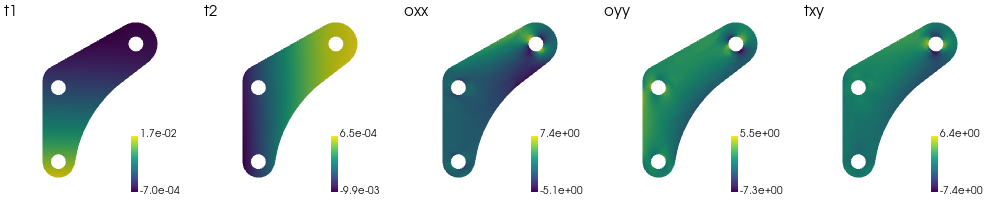

In [283]:
# assumes nodes ids are contiguous and start at 1
def loadOptistructModel(op2File):
    geom = read_op2_geom(op2File, build_dataframe=True, debug=False)
    nodeDict = geom.nodes
    elemDict = geom.elements
    vertices = np.array([n.get_position() for nid, n in nodeDict.items()])
    vertices -= np.mean(vertices, axis=0)
    vertices /= np.linalg.norm(vertices, axis=1).max()
    faces = np.array([[len(e.nodes)] + [nid-1 for nid in e.nodes] for eid, e in elemDict.items()]).flatten()
    mesh = pv.PolyData(vertices, faces, n_faces=len(elemDict))
    return mesh

# assumes nodes ids are contiguous and start at 1
def loadOptistructResults(op2File, loadNodalStress=False, colNames=['t1', 't2'], geom=None):
    res = read_op2(op2File, build_dataframe=True, debug=False, mode='optistruct');
    resDf = res.displacements[1].data_frame
    resDf = resDf.set_index('NodeID')
    
    if loadNodalStress:
        colNames += ['oxx', 'oyy', 'txy', 'von_mises']
        stressDf = res.cquad4_stress[1].data_frame
        geom = read_op2_geom(op2File, build_dataframe=True, debug=False)
        stressDf = transformStressToMatCordSys(stressDf, geom)        
        nodeStressDf = stressDf.groupby('NodeID').mean().drop('CEN')
        resDf = resDf.join(nodeStressDf)

    resDf = resDf[colNames]
    return resDf

# a (slow) method for transforming stresses from elemental coordinate
# system to global coordinate system
def transformStressToMatCordSys(stressDf, geom):
    # T = [xmaterial or xelement, y, normal]
    # sigma_elemental = [oxx,txy,0], [txy,oyy,0],[0,0,0]
    for index, row in stressDf.iterrows():
        eid = index[0]
        T = np.vstack(geom.Element(eid).material_coordinate_system())[1:,:]
        stressElemental = np.array([[row.oxx, row.txy, 0], [row.txy, row.oyy, 0], [0, 0, 0]])
        stressElementalGlobal = np.matmul(T.T,np.matmul(stressElemental,T))
        stressDf.at[index,'oxx'] = stressElementalGlobal[0,0]
        stressDf.at[index,'oyy'] = stressElementalGlobal[1,1]
        stressDf.at[index,'txy'] = stressElementalGlobal[1,0]

    return stressDf

def plotScalarFields(mesh, resDf, fieldList=['t1', 't2', 'oxx', 'oyy', 'txy'], cpos='xy'):
    plotter = pv.Plotter(shape=(1,len(fieldList)), border=False)
    for i,field in enumerate(fieldList):
        plotter.subplot(0,i)
        plotter.set_background('white')
        plotter.add_text(field, color='k', font_size=7)
        plotter.add_mesh(mesh.copy(), show_edges=False, scalars=resDf[field])
        plotter.add_scalar_bar(n_labels=2, label_font_size=10, width=0.1, height=0.3, 
                               vertical=True, position_x=0.65, fmt="%.1e", color='k')
    
    plotter.show(window_size=(200*len(fieldList),200), cpos=cpos);
    
    
def pyvistaToTrimesh(mesh):
    pvTriMesh = pv.PolyDataFilters.triangulate(mesh)
    faces = pvTriMesh.faces.reshape(-1,4)[:,1:]
    points = pvTriMesh.points
    return trimesh.Trimesh(points, faces, process=False)

def getAllBoundaries(mesh):
    bndEdges = mesh.extract_feature_edges(boundary_edges=True, non_manifold_edges=False, feature_edges=False, manifold_edges=False)
    bndEdgesCon = bndEdges.connectivity()
    bndIds = np.unique(bndEdgesCon['RegionId'])
    bndDict = {}
    for bndId in bndIds:
        cellIds = np.where(bndEdgesCon.cell_arrays['RegionId']==bndId)
        bndDict[bndId] = bndEdgesCon.extract_cells(cellIds)
    
    return bndDict

def getEdgeNormals(bnd):
    perp = [0,0,1]
    edgeNormals = np.zeros((bnd.n_cells,3))
    com = np.mean(bnd.points, axis=0)
    dirs = np.zeros(bnd.n_cells)

    # get first normal
    vi,vj = bnd.extract_cells(0).points
    nv = np.cross(vi-vj,np.array(perp))
    edgeNormals[0,:] = nv / np.linalg.norm(nv)

    # get the rest
    for eid in range(1, bnd.n_cells):
        vi,vj = bnd.extract_cells(eid).points
        nv = np.cross(vi-vj,np.array(perp))
        nv /= np.linalg.norm(nv)
        nv *= np.sign(np.dot(nv,edgeNormals[eid-1,:]))
        edgeNormals[eid,:] = nv
        dirs[eid] = np.dot(0.5*(vi+vj)-com, nv)

    edgeNormals = edgeNormals * np.sign(np.mean(dirs)) # point outwards
    
    return edgeNormals

def getEdgeLength(bnd):
    L = 0
    for eid in range(1, bnd.n_cells):
        vi,vj = bnd.extract_cells(eid).points
        L += np.linalg.norm(vi-vj)
    return L
    
def force2Traction(bnd, F, t):
    L = getEdgeLength(bnd)
    return F/(L*t)

def sampleDomain(mesh, N, seed=1234):
    tmesh = pyvistaToTrimesh(mesh)
    np.random.seed(seed)
    samples, face_index = trimesh.sample.sample_surface_even(tmesh, N)
    return samples

def sampleBoundary(bnd, N, includeNormals=False, seed=1234):
    np.random.seed(seed)
    samples = np.zeros((N,3))
    
    if includeNormals:
        normals = np.zeros((N,3))
        edgeNormals = getEdgeNormals(bnd)
        
    for n in range(N):
        eid = np.random.choice(range(bnd.n_cells))
        edge = bnd.extract_cells(eid)
        vi,vj = edge.points
        w = np.random.rand()
        p = w*vi+(1-w)*vj
        samples[n,:] = p
        
        if includeNormals:
            normals[n,:] = edgeNormals[eid,:]
        
    if includeNormals:
        return samples, normals

    return samples

def plotField(x, mesh=None, scalar=None, interpolate=False):
    # point coordinates
    x = np.hstack((x, np.zeros((x.shape[0],1))))
    pc = pv.PolyData(x)

    plotter = pv.Plotter(border=False)
    plotter.set_background('white')
    if interpolate:
        pc['field'] = scalar
        vertScalars = mesh.copy().interpolate(pc)['field']
        plotter.add_mesh(mesh, show_edges=False, scalars=vertScalars)
        plotter.add_scalar_bar(n_labels=2, label_font_size=10, width=0.1, height=0.3, 
                                   vertical=True, position_x=0.65, fmt="%.1e", color='k')
    else:
        if mesh is not None:
            plotter.add_mesh(mesh, show_edges=False)
        if scalar is not None:
            plotter.add_mesh(pc, render_points_as_spheres=True, scalars=scalar)
            plotter.add_scalar_bar(n_labels=2, label_font_size=10, width=0.1, height=0.3, 
                                   vertical=True, position_x=0.65, fmt="%.1e", color='k')
        else:
            plotter.add_mesh(pc, render_points_as_spheres=True, color='gray')
    
    plotter.show(window_size=(400,400), cpos='xy');
    

op2File = 'data/controlArm/v1.0/controlArm01_nom.op2'
mesh = loadOptistructModel(op2File)
resDf = loadOptistructResults(op2File, loadNodalStress=True)


# op2File = 'data/controlArm/v1.0/controlArm01_high.op2'
# resDfH = loadOptistructResults(op2File, loadNodalStress=True)
# meshH = loadOptistructModel(op2File)

# op2File = 'data/controlArm/v1.0/controlArm01_low.op2'
# resDfL = loadOptistructResults(op2File, loadNodalStress=True)
# meshL = loadOptistructModel(op2File)

# plotScalarFields(meshL, resDfL)
plotScalarFields(mesh, resDf)
# plotScalarFields(meshH, resDfH)

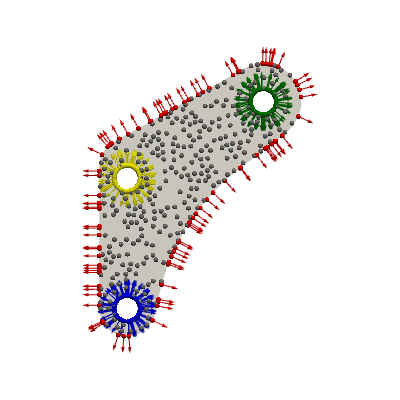

In [4]:
plotter = pv.Plotter(border=False)
plotter.set_background('white')
plotter.add_mesh(mesh, show_edges=False)

# sample domain
samples = sampleDomain(mesh, 300)
pc = pv.PolyData(samples)
plotter.add_mesh(pc, render_points_as_spheres=True, color='gray')

# sample boundary
bndDict = getAllBoundaries(mesh)
for bndId, color in zip(bndDict.keys(), ['red', 'green', 'blue', 'yellow']):
    samples, normals = sampleBoundary(bndDict[bndId], 100, includeNormals=True)
    pc = pv.PolyData(samples)
    plotter.add_mesh(pc, render_points_as_spheres=True, color=color)
    plotter.add_arrows(samples, normals, 0.1, color=color)

plotter.show(window_size=(400,400), cpos='xy');

# Test on Poisson Problem

In [5]:
# import deepxde as dde
import deepxde as dde

Using TensorFlow 2 backend.

Instructions for updating:
non-resource variables are not supported in the long term


Compiling model...
Building feed-forward neural network...
'build' took 0.046876 s



C:\Users\ewhalen\Miniconda3\envs\pinnDSE\lib\site-packages\tensorflow\python\keras\legacy_tf_layers\core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
C:\Users\ewhalen\Miniconda3\envs\pinnDSE\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 1.451264 s

Initializing variables...
Training model...

Step      Train loss                                                                                                                            Test loss                                                                                                                             Test metric
0         [1.28e-01, 2.85e-02, 7.57e+09, 1.91e+09, 9.71e+08, 1.06e-02, 5.77e-03, 6.18e-03, 6.17e-03, 2.47e+03, 3.35e-03, 3.73e-03, 6.39e-03]    [1.32e-01, 2.93e-02, 7.74e+09, 1.92e+09, 9.92e+08, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
100       [1.53e-02, 1.25e-03, 9.96e+04, 8.21e+05, 8.39e+04, 6.46e-05, 3.65e-07, 2.12e-03, 3.42e-03, 2.47e+03, 3.65e-03, 1.06e-03, 1.50e-03]    [1.60e-02, 1.33e-03, 6.03e+04, 5.73e+05, 5.07e+04, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
200       [1.03e-03, 3.64e-04, 5.32e+04, 3.09e+05, 4.47e+04, 1.43e-05, 1

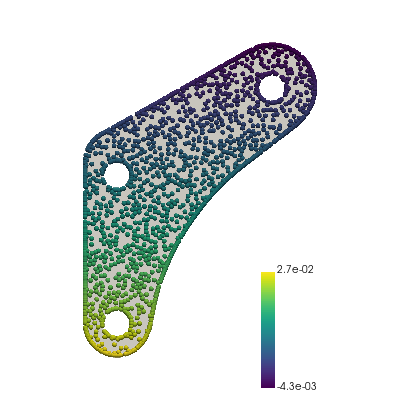

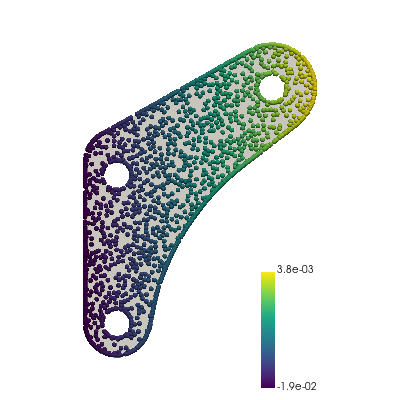

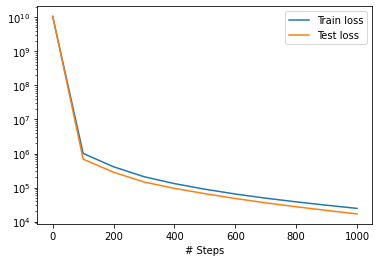

In [149]:
#################################################
class MeshGeom(dde.geometry.geometry.Geometry):
    def __init__(self, op2File):
        self.dim = 2
        self.idstr = 'MeshGeom'
#         self.resDf = loadOptistructResults(op2File, loadNodalStress=True)
        self.mesh = loadOptistructModel(op2File)
        self.bndDict = getAllBoundaries(self.mesh)

    
    def random_points(self, n, random="pseudo", seed=1234):
        samples = sampleDomain(self.mesh, n, seed=seed)
        return samples[:,:2]
    
    def random_boundary_points(self, n, bndId, random="pseudo", seed=1234):
        samples, normals = sampleBoundary(self.bndDict[bndId], n, includeNormals=True, seed=1234)
        return samples[:,:2], normals[:,:2]

#################################################
class TractionBC(dde.boundary_conditions.BC):
    def __init__(self, geom, func, boundary, T):
        self.geom = geom
        self.func = func
        self.T = T
        
    def error(self, train_x, inputs, outputs, beg, end):
        return self.func(train_x, inputs, outputs, self.train_n, self.T)[beg:end]
    
#################################################
class PDE2(dde.data.pde.PDE):
    def __init__(
        self,
        geometry,
        pde,
        bcs,
        num_domain=0,
        num_boundary_dir={},
        train_distribution="sobol",
        anchors=None,
        exclusions=None,
        solution=None,
        num_test=None,
        auxiliary_var_function=None,
    ):
        self.geom = geometry
        self.pde = pde
        self.bcs = bcs if isinstance(bcs, (list, tuple)) else [bcs]

        self.num_domain = num_domain
        self.num_boundary_dir = num_boundary_dir
        if train_distribution not in ["uniform", "pseudo", "sobol"]:
            raise ValueError(
                "train_distribution == {}. Available choices: {{'uniform'|'pseudo'|'sobol'}}.".format(
                    train_distribution
                )
            )
        self.train_distribution = train_distribution
        self.anchors = anchors
        self.exclusions = exclusions

        self.soln = solution
        self.num_test = num_test

        self.auxiliary_var_fn = auxiliary_var_function

        self.train_x_all = None
        self.train_x, self.train_y = None, None
        self.train_x_bc = None
        self.num_bcs = None
        self.test_x, self.test_y = None, None
        self.train_aux_vars, self.test_aux_vars = None, None

        # sample domain and each boundary
        domainSamples = self.geom.random_points(num_domain)
        bndSampleDict = {}
        bndNormalsDict = {}
        for bndId in geom.bndDict.keys():
            samples, normals = self.geom.random_boundary_points(num_boundary_dir[bndId], bndId)
            bndSampleDict[bndId] = samples
            bndNormalsDict[bndId] = normals
    
        # organize by which bc they belong to
        x_bcs = [bndSampleDict[bc.bndId] for bc in self.bcs] # bcs will have a bndId attribute
        n_bcs = [bndNormalsDict[bc.bndId] for bc in self.bcs]
        self.num_bcs = list(map(len, x_bcs))
        self.train_x_bc = (np.vstack(x_bcs) if x_bcs else np.empty([0, self.train_x_all.shape[-1]]))
        self.train_n_bc = (np.vstack(n_bcs) if n_bcs else np.empty([0, self.train_x_all.shape[-1]]))
        
        # create final training arrays
        self.train_x_all = np.vstack([domainSamples]+list(bndSampleDict.values()))
        self.train_x = np.vstack((self.train_x_bc, self.train_x_all)) # stack bc and then all points (contains duplicates)
        self.train_n = np.vstack((self.train_n_bc, np.zeros_like(self.train_x_all)))
        self.train_y = self.soln(self.train_x) if self.soln else None
        
        self.test_x = self.geom.random_points(self.num_test, seed=1)
        self.test_y = self.soln(self.test_x) if self.soln else None
    
###########################ELASTICITY#######################################
op2File = 'data/controlArm/v1.0/controlArm01_nom.op2'
geom = MeshGeom(op2File)  

# material properties
E = 2e5 # (MPa)
nu = 0.3
t = 0.1
        
# elasticity equations
def pde(inputs, outputs):
    # get the spatial derivatives of stress
    dSigX_dx = dde.gradients.jacobian(outputs, inputs, i=2, j=0)
    dSigY_dy = dde.gradients.jacobian(outputs, inputs, i=3, j=1)
    dSigXY_dx = dde.gradients.jacobian(outputs, inputs, i=4, j=0)
    dSigXY_dy = dde.gradients.jacobian(outputs, inputs, i=4, j=1)

    # calculate the divergence of stress
    divSigX = dSigX_dx + dSigXY_dy
    divSigY = dSigXY_dx + dSigY_dy

    # get the spatial derivatives of displacement
    dU_dx = dde.gradients.jacobian(outputs, inputs, i=0, j=0)
    dU_dy = dde.gradients.jacobian(outputs, inputs, i=0, j=1)
    dV_dx = dde.gradients.jacobian(outputs, inputs, i=1, j=0)
    dV_dy = dde.gradients.jacobian(outputs, inputs, i=1, j=1)

    # calculate the stress residuals
    sigX, sigY, sigXY = outputs[:, 2:3], outputs[:, 3:4], outputs[:, 4:]
    resSigX = (E/(1-nu**2))*(dU_dx + nu*dV_dy) - sigX
    resSigXY = (E/(2*(1+nu)))*(dU_dy + dV_dx) - sigXY
    resSigY = (E/(1-nu**2))*(dV_dy + nu*dU_dx) - sigY
    return [divSigX, divSigY, resSigX, resSigY, resSigXY]

def boundary(_, on_boundary):
    return on_boundary

# CLAMP in x-direction U = 0
xBc = dde.DirichletBC(geom, lambda x: 0, boundary, component=0)
xBc.bndId = 1

# CLAMP in y-direction  V = 0
yBc = dde.DirichletBC(geom, lambda x: 0, boundary, component=1)
yBc.bndId = 1

def tractionX(train_x, inputs, outputs, train_n, Tx): # needs normals and Tx
    sigX = outputs[:,2]
    sigXY = outputs[:,4]
    nx = train_n[:,0]
    ny = train_n[:,1]
    return sigX*nx + sigXY*ny - Tx

def tractionY(train_x, inputs, outputs, train_n, Ty): # needs normals and Tx
    sigY = outputs[:,3]
    sigXY = outputs[:,4]
    nx = train_n[:,0]
    ny = train_n[:,1]
    return sigXY*nx + sigY*ny - Ty

# traction 
xTr0 = TractionBC(geom, tractionX, boundary, 0)
xTr0.bndId = 0
yTr0 = TractionBC(geom, tractionY, boundary, 0)
yTr0.bndId = 0

xTr3 = TractionBC(geom, tractionX, boundary, 0)
xTr3.bndId = 3
yTr3 = TractionBC(geom, tractionY, boundary, 0)
yTr3.bndId = 3

Fx = 22 # N
Tx = force2Traction(geom.bndDict[bndId],Fx,t)
xTr2 = TractionBC(geom, tractionX, boundary, Tx)
xTr2.bndId = 2

yTr2 = TractionBC(geom, tractionY, boundary, 0)
yTr2.bndId = 2

num_boundary_dir = {0:800, 1:50, 2:50, 3:50}
data = PDE2(geom, pde, [xBc,yBc,xTr0,yTr0,xTr2,yTr2,xTr3,yTr3], num_domain=1000, num_boundary_dir=num_boundary_dir, num_test=500)

xTr0.train_n = data.train_n
yTr0.train_n = data.train_n
xTr2.train_n = data.train_n
yTr2.train_n = data.train_n
xTr3.train_n = data.train_n
yTr3.train_n = data.train_n

net = dde.maps.FNN([2] + [64]*4  + [5], "tanh", "Glorot uniform")
model = dde.Model(data, net)

model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=1000, display_every=100)
dde.postprocessing.plot_loss_history(losshistory)

pred = model.predict(data.train_x)
plotField(data.train_x, mesh=geom.mesh, scalar=pred[:,0])

plotField(data.train_x, mesh=geom.mesh, scalar=pred[:,1])

# pred = model.predict(data.test_x)
# plotField(data.test_x, mesh=geom.mesh, scalar=pred[:,0])

In [42]:
# # ############################POISSON#######################################
# op2File = 'data/controlArm/v1.0/controlArm01_nom.op2'
# geom = MeshGeom(op2File)   
        
# def pde(x, y):
#     dy_xx = dde.grad.hessian(y, x, i=0, j=0)
#     dy_yy = dde.grad.hessian(y, x, i=1, j=1)
#     return -dy_xx - dy_yy - 1

# # dummy function. BCs expect a boundary function but we don't actually use it
# def f(): return true

# bc0 = dde.DirichletBC(geom, lambda x: 0, f)
# bc0.bndId = 0

# bc1 = dde.DirichletBC(geom, lambda x: 0, f)
# bc1.bndId = 1

# bc2 = dde.DirichletBC(geom, lambda x: 1, f)
# bc2.bndId = 2

# bc3 = dde.DirichletBC(geom, lambda x: 0, f)
# bc3.bndId = 3

# num_boundary_dir = {0:800, 1:50, 2:50, 3:50}
# data = PDE2(geom, pde, [bc0,bc1,bc2,bc3], num_domain=1000, num_boundary_dir=num_boundary_dir, num_test=500)
# net = dde.maps.FNN([2] + [50] * 4 + [1], "tanh", "Glorot uniform")
# model = dde.Model(data, net)

# model.compile("adam", lr=0.001)
# losshistory, train_state = model.train(epochs=100, display_every=10)
# dde.postprocessing.plot_loss_history(losshistory)

# pred = model.predict(data.train_x)
# plotField(data.train_x, mesh=geom.mesh, scalar=pred)

# pred = model.predict(data.test_x)
# plotField(data.test_x, mesh=geom.mesh, scalar=pred)

In [ ]:
############################ELASTICITY#######################################
# op2File = 'data/controlArm/v1.0/controlArm01_nom.op2'
# geom = MeshGeom(op2File)   
        
# def pde(x, y):
#     # get the spatial derivatives of stress
#     dSigx_dx = dde.gradients.jacobian(y, x, i=2, j=0)
#     dSigy_dy = dde.gradients.jacobian(y, x, i=3, j=1)
#     dSigxy_dx = dde.gradients.jacobian(y, x, i=4, j=0)
#     dSigxy_dy = dde.gradients.jacobian(y, x, i=4, j=1)

#     # calculate the divergence of stress
#     divSigX = dSigx_dx + dSigxy_dy
#     divSigY = dSigxy_dx + dSigy_dy

#     # get the spatial derivatives of displacement
#     dU_dx = dde.gradients.jacobian(y, x, i=0, j=0)
#     dU_dy = dde.gradients.jacobian(y, x, i=0, j=1)
#     dV_dx = dde.gradients.jacobian(y, x, i=1, j=0)
#     dV_dy = dde.gradients.jacobian(y, x, i=1, j=1)

#     # calculate the stress residuals
#     sigX, sigY, sigXY = y[:, 2:3], y[:, 3:4], y[:, 4:]
#     resSigX = (E/(1-nu**2))*(dU_dx + nu*dV_dy) - sigX
#     resSigXY = (E/(2*(1+nu)))*(dU_dy + dV_dx) - sigXY
#     resSigY = (E/(1-nu**2))*(dV_dy + nu*dU_dx) - sigY
#     return [divSigX, divSigY, resSigX, resSigY, resSigXY]

# def boundary(_, on_boundary):
#     return on_boundary

# bc0 = dde.DirichletBC(geom, lambda x: 0, boundary)
# bc0.bndId = 0

# bc1 = dde.DirichletBC(geom, lambda x: 0, boundary)
# bc1.bndId = 1

# bc2 = dde.DirichletBC(geom, lambda x: 1, boundary)
# bc2.bndId = 2

# bc3 = dde.DirichletBC(geom, lambda x: 0, boundary)
# bc3.bndId = 3

# num_boundary_dir = {0:800, 1:50, 2:50, 3:50}
# data = PDE2(geom, pde, [bc0,bc1,bc2,bc3], num_domain=1000, num_boundary_dir=num_boundary_dir, num_test=500)
# net = dde.maps.FNN([2] + [50] * 4 + [1], "tanh", "Glorot uniform")
# model = dde.Model(data, net)

# model.compile("adam", lr=0.001)
# losshistory, train_state = model.train(epochs=100, display_every=10)
# dde.postprocessing.plot_loss_history(losshistory)

# pred = model.predict(data.train_x)
# plotField(data.train_x, mesh=geom.mesh, scalar=pred)

# pred = model.predict(data.test_x)
# plotField(data.test_x, mesh=geom.mesh, scalar=pred)

In [ ]:
# get data labels
# scale data labels
# finalize FEA model
# traaaaain